<b>Installing Libraries</b>

In [ ]:
%pip install matplotlib
%pip install seaborn
%pip install plotly
%pip install scipy
%pip install scikit-learn
%pip install xgboost
%pip install lightgbm

<b>Importing Libraries</b>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

''' Core ML '''
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

''' Advanced ML '''
try:
    import xgboost as xgb
    from lightgbm import LGBMRegressor
    ADVANCED_MODELS = True
    print("Advanced ML libraries loaded successfully!")
except ImportError:
    ADVANCED_MODELS = False
    print("Advanced libraries not available. Using sklearn alternatives.")

''' Statistical libraries '''
from scipy import stats
from scipy.stats import skew, kurtosis, normaltest

Advanced ML libraries loaded successfully!


<b>Setting a style makes plots look better</b>

In [ ]:
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

<b>Loading the data and Exploring it</b>

In [20]:
class HousePricePredictor:
    """ Class for house price prediction while using OOP principles """
    
    def __init__(self):
        self.train_data = None
        self.test_data = None
        self.X_train = None
        self.X_val = None
        self.y_train = None
        self.y_val = None
        self.models = {}
        self.feature_importance = {}
        self.preprocessing_pipeline = None
        
    def load_and_explore_data(self):
        """Loading datasets and performing initial exploration"""
        try:
            print("Loading datasets...")
            self.train_data = pd.read_csv('train.csv')
            self.test_data = pd.read_csv('test.csv')
            
            print(f"Training data loaded: {self.train_data.shape}")
            print(f"Test data loaded: {self.test_data.shape}")
            
        except FileNotFoundError:
            print("Dataset files not found. Creating sample data for demonstration...")
            self._create_sample_data()
        
        self._initial_data_exploration()
        
    def _create_sample_data(self):
        """Createing realistic sample data based on Ames housing characteristics"""
        
        print("Generating sample data based on Ames housing patterns...")
        
        np.random.seed(42)  # For reproducibility
        n_train, n_test = 1460, 1459  # Actual Kaggle dataset sizes
        
        # Realistic feature distributions based on Ames housing data
        def generate_features(n_samples):
            # Numerical features with realistic distributions
            lot_area = np.random.lognormal(9.4, 0.5, n_samples)  # Log-normal for area
            year_built = np.random.randint(1872, 2011, n_samples)
            overall_qual = np.random.choice(range(1, 11), n_samples, 
                                          p=[0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.2, 0.15, 0.08, 0.02])
            
            gr_liv_area = np.random.normal(1500, 500, n_samples)
            gr_liv_area = np.maximum(gr_liv_area, 334)  # Minimum realistic size
            
            total_bsmt_sf = np.random.normal(1000, 400, n_samples)
            total_bsmt_sf = np.maximum(total_bsmt_sf, 0)
            
            garage_cars = np.random.choice([0, 1, 2, 3, 4], n_samples, 
                                         p=[0.05, 0.15, 0.55, 0.22, 0.03])
            
            # Categorical features with realistic distributions  
            neighborhoods = ['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 
                           'Somerst', 'Timber', 'StoneBr', 'Blmngtn', 'ClearCr', 'BrkSide']
            
            return pd.DataFrame({
                'Id': range(1, n_samples + 1),
                'LotArea': lot_area,
                'YearBuilt': year_built,
                'OverallQual': overall_qual,
                'OverallCond': np.random.choice(range(1, 10), n_samples),
                'GrLivArea': gr_liv_area,
                'TotalBsmtSF': total_bsmt_sf,
                'GarageCars': garage_cars,
                'GarageArea': garage_cars * 250 + np.random.normal(0, 50, n_samples),
                'FullBath': np.random.choice([1, 2, 3], n_samples, p=[0.3, 0.6, 0.1]),
                'BedroomAbvGr': np.random.choice([2, 3, 4, 5], n_samples, p=[0.2, 0.5, 0.25, 0.05]),
                'TotRmsAbvGrd': np.random.choice(range(4, 13), n_samples),
                'Fireplaces': np.random.choice([0, 1, 2], n_samples, p=[0.4, 0.5, 0.1]),
                'MSZoning': np.random.choice(['RL', 'RM', 'FV', 'RH'], n_samples, p=[0.8, 0.1, 0.05, 0.05]),
                'Neighborhood': np.random.choice(neighborhoods, n_samples),
                'HouseStyle': np.random.choice(['2Story', '1Story', '1.5Fin', 'SLvl'], n_samples),
                'ExterQual': np.random.choice(['Ex', 'Gd', 'TA', 'Fa'], n_samples, p=[0.1, 0.5, 0.35, 0.05]),
                'KitchenQual': np.random.choice(['Ex', 'Gd', 'TA', 'Fa'], n_samples, p=[0.15, 0.6, 0.23, 0.02]),
            })
        
        # Generateing training data
        self.train_data = generate_features(n_train)
        
        # Creating target variable with realistic relationships
        # Approach: Multiple factors affecting price
        self.train_data['SalePrice'] = (
            self.train_data['OverallQual'] * 15000 +  # Quality is major factor
            self.train_data['GrLivArea'] * 60 +       # Size matters
            (self.train_data['YearBuilt'] - 1900) * 200 +  # Age factor
            self.train_data['GarageCars'] * 8000 +    # Garage premium
            np.where(self.train_data['Neighborhood'].isin(['NoRidge', 'StoneBr']), 25000, 0) +  # Premium neighborhoods
            np.random.normal(0, 20000, n_train)       # Random variation
        )
        
        # Ensuring realistic price range
        self.train_data['SalePrice'] = np.clip(self.train_data['SalePrice'], 34900, 755000)
        
        # Generating test data
        self.test_data = generate_features(n_test)
        self.test_data['Id'] = range(n_train + 1, n_train + n_test + 1)
        
        print("Sample data generated successfully!")
        
    def _initial_data_exploration(self):
        """Comprehensive initial data exploration"""
        print("\nInitial Data Exploration")
        print("=" * 40)
        
        # Basic info
        print(f"Training samples: {len(self.train_data):,}")
        print(f"Features: {len(self.train_data.columns)-1}")  # Excluding target
        print("Target variable: SalePrice")
        
        # Data types analysis
        print(f"\n Numerical features: {self.train_data.select_dtypes(include=[np.number]).shape[1]}")
        print(f"Categorical features: {self.train_data.select_dtypes(include=['object']).shape[1]}")
        
        # Missing values summary
        missing_data = self.train_data.isnull().sum()
        if missing_data.sum() > 0:
            print(f"\nTotal missing values: {missing_data.sum()}")
            print("Top missing features:")
            print(missing_data[missing_data > 0].sort_values(ascending=False).head())
        else:
            print("\nNo missing values detected in sample data")
        
        # Target variable analysis
        if 'SalePrice' in self.train_data.columns:
            price_stats = self.train_data['SalePrice'].describe()
            print("\nSALE PRICE ANALYSIS")
            print(f"Mean: ${price_stats['mean']:,.0f}")
            print(f"Median: ${price_stats['50%']:,.0f}")
            print(f"Range: ${price_stats['min']:,.0f} - ${price_stats['max']:,.0f}")
            print(f"Skewness: {skew(self.train_data['SalePrice']):.3f}")
            
    def comprehensive_eda(self):
        """Perform comprehensive exploratory data analysis"""
        print("\nComprehensive Exploratory Data Analysis")
        print("=" * 50)
        
        # Creating subplots for comprehensive analysis
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('House Prices - Comprehensive EDA Dashboard', fontsize=16, fontweight='bold')
        
        # 1. Target distribution
        axes[0,0].hist(self.train_data['SalePrice'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].set_title('Sale Price Distribution', fontweight='bold')
        axes[0,0].set_xlabel('Sale Price ($)')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].axvline(self.train_data['SalePrice'].mean(), color='red', linestyle='--', label='Mean')
        axes[0,0].axvline(self.train_data['SalePrice'].median(), color='green', linestyle='--', label='Median')
        axes[0,0].legend()
        
        # 2. Log-transformed target (professional insight)
        log_prices = np.log1p(self.train_data['SalePrice'])
        axes[0,1].hist(log_prices, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[0,1].set_title('Log-Transformed Sale Price', fontweight='bold')
        axes[0,1].set_xlabel('Log(Sale Price)')
        axes[0,1].set_ylabel('Frequency')
        print(f"Skewness improvement: {skew(self.train_data['SalePrice']):.3f} → {skew(log_prices):.3f}")
        
        # 3. Price vs Living Area (key relationship)
        if 'GrLivArea' in self.train_data.columns:
            axes[0,2].scatter(self.train_data['GrLivArea'], self.train_data['SalePrice'], 
                            alpha=0.6, color='green', s=30)
            axes[0,2].set_title('Price vs Living Area', fontweight='bold')
            axes[0,2].set_xlabel('Above Ground Living Area (sq ft)')
            axes[0,2].set_ylabel('Sale Price ($)')
            
            # Adding correlation coefficient
            correlation = self.train_data['GrLivArea'].corr(self.train_data['SalePrice'])
            axes[0,2].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                          transform=axes[0,2].transAxes, fontweight='bold',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # 4. Overall Quality impact (categorical analysis)
        if 'OverallQual' in self.train_data.columns:
            quality_price = self.train_data.groupby('OverallQual')['SalePrice'].mean()
            axes[1,0].bar(quality_price.index, quality_price.values, color='orange', alpha=0.7)
            axes[1,0].set_title('Average Price by Overall Quality', fontweight='bold')
            axes[1,0].set_xlabel('Overall Quality Rating')
            axes[1,0].set_ylabel('Average Sale Price ($)')
        
        # 5. Year Built analysis (time trend)
        if 'YearBuilt' in self.train_data.columns:
            # Create decade groups for cleaner visualization
            self.train_data['Decade'] = (self.train_data['YearBuilt'] // 10) * 10
            decade_price = self.train_data.groupby('Decade')['SalePrice'].mean()
            axes[1,1].plot(decade_price.index, decade_price.values, 
                          marker='o', linewidth=2, markersize=6, color='purple')
            axes[1,1].set_title('Price Trend by Construction Decade', fontweight='bold')
            axes[1,1].set_xlabel('Construction Decade')
            axes[1,1].set_ylabel('Average Sale Price ($)')
            axes[1,1].grid(True, alpha=0.3)
        
        # 6. Correlation heatmap (top features)
        numerical_cols = self.train_data.select_dtypes(include=[np.number]).columns
        if len(numerical_cols) > 1:
            corr_matrix = self.train_data[numerical_cols].corr()['SalePrice'].abs().sort_values(ascending=False)
            top_features = corr_matrix.head(10).index
            
            sns.heatmap(self.train_data[top_features].corr(), 
                       annot=True, cmap='RdYlBu_r', center=0,
                       ax=axes[1,2], fmt='.2f', square=True)
            axes[1,2].set_title('Top Features Correlation Matrix', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Feature importance insights
        print("\nKey Insights from Eda:")
        if 'SalePrice' in self.train_data.columns:
            numerical_cols = self.train_data.select_dtypes(include=[np.number]).columns
            correlations = self.train_data[numerical_cols].corr()['SalePrice'].abs().sort_values(ascending=False)
            
            print("Top 5 Most Correlated Features:")
            for i, (feature, corr) in enumerate(correlations.head(6)[1:].items(), 1):
                print(f"  {i}. {feature}: {corr:.3f}")
        
    def advanced_feature_engineering(self):
        print("\nAdvanced Feature Engineering")
        print("=" * 45)
        
        # Combining train and test for consistent feature engineering
        combined_data = pd.concat([self.train_data.drop('SalePrice', axis=1), self.test_data], 
                                 ignore_index=True, sort=False)
        
        print(f"Combined dataset shape: {combined_data.shape}")
        
        ''' 1. Mathematical Transformations '''
        print("\n 1.Mathematical Transformations")
        
        # Total square footage 
        if all(col in combined_data.columns for col in ['TotalBsmtSF', 'GrLivArea']):
            combined_data['TotalSF'] = combined_data['TotalBsmtSF'] + combined_data['GrLivArea']
            print("Created TotalSF (Basement + Living Area)")
        
        # Area ratios 
        if 'LotArea' in combined_data.columns and 'GrLivArea' in combined_data.columns:
            combined_data['LivingAreaRatio'] = combined_data['GrLivArea'] / combined_data['LotArea']
            print("Created LivingAreaRatio (efficiency metric)")
        
        # Age-related features
        if 'YearBuilt' in combined_data.columns:
            current_year = 2024  # As of project date
            combined_data['HouseAge'] = current_year - combined_data['YearBuilt']
            combined_data['IsNew'] = (combined_data['HouseAge'] <= 5).astype(int)
            print("Created HouseAge and IsNew features")
        
        # Bathroom features (lifestyle factors)
        if all(col in combined_data.columns for col in ['FullBath', 'HalfBath']):
            combined_data['TotalBath'] = combined_data['FullBath'] + combined_data['HalfBath'] * 0.5
            print("Created TotalBath feature")
        
        ''' 2. Categorical Feature Engineering '''
        print("\n 2.Categorical Feature Engineering")
        
        # Neighborhood grouping (market segmentation)
        if 'Neighborhood' in combined_data.columns:
            # Group neighborhoods by price level (would use actual data in production)
            premium_neighborhoods = ['NoRidge', 'StoneBr', 'Veenker']
            combined_data['NeighborhoodGroup'] = combined_data['Neighborhood'].apply(
                lambda x: 'Premium' if x in premium_neighborhoods else 'Standard'
            )
            print("Created NeighborhoodGroup (market segmentation)")
        
        # Quality score combinations
        if 'OverallQual' in combined_data.columns and 'OverallCond' in combined_data.columns:
            combined_data['QualityScore'] = combined_data['OverallQual'] * combined_data['OverallCond']
            print("Created QualityScore (Quality × Condition)")
        
        ''' 3. Interaction Features '''
        print("\n 3. Interaction Features")
        
        # Size × Quality interaction
        if all(col in combined_data.columns for col in ['GrLivArea', 'OverallQual']):
            combined_data['SizeQualityInteraction'] = combined_data['GrLivArea'] * combined_data['OverallQual']
            print("Created SizeQualityInteraction")
        
        # Garage interaction
        if 'GarageCars' in combined_data.columns and 'GarageArea' in combined_data.columns:
            combined_data['GarageScore'] = combined_data['GarageCars'] * combined_data['GarageArea']
            combined_data['HasGarage'] = (combined_data['GarageCars'] > 0).astype(int)
            print("Created GarageScore and HasGarage")
        
        ''' 4. Statistical Transformations '''
        print("\n 4.Statistical Transformations")
        
        # Identifing skewed numerical features for transformation
        numerical_features = combined_data.select_dtypes(include=[np.number]).columns
        skewed_features = []
        
        for feature in numerical_features:
            if combined_data[feature].nunique() > 10:  # Avoid transforming categorical-like features
                skewness = skew(combined_data[feature].dropna())
                if abs(skewness) > 0.75:  # Threshold for skewness
                    skewed_features.append(feature)
        
        print(f"Identified {len(skewed_features)} skewed features for transformation")
        
        # Appling log transformation to skewed features
        for feature in skewed_features[:5]:  # Limit to avoid over-transformation
            if (combined_data[feature] > 0).all():  # Ensure positive values
                combined_data[f'{feature}_log'] = np.log1p(combined_data[feature])
                print(f"Log-transformed {feature}")
        
        ''' 5. Missing Value Treatment '''
        print("\n 5.Advanced Missing Value Treatment")
        
        missing_counts = combined_data.isnull().sum()
        if missing_counts.sum() > 0:
            print(f"Total missing values: {missing_counts.sum()}")
            
            # Domain-specific imputation
            for col in combined_data.columns:
                if combined_data[col].isnull().sum() > 0:
                    if combined_data[col].dtype == 'object':
                        # Categorical: mode or 'None'
                        combined_data[col].fillna(combined_data[col].mode().iloc[0] if len(combined_data[col].mode()) > 0 else 'None', inplace=True)
                    else:
                        # Numerical: median (robust to outliers)
                        combined_data[col].fillna(combined_data[col].median(), inplace=True)
            
            print("Applied domain-specific missing value imputation")
        else:
            print("No missing values to handle")
        
        ''' 6. Feature Scaling '''
        print("\n 6.Feature Scaling Preparation")
        
        # Identifing features that need scaling
        high_variance_features = []
        for col in combined_data.select_dtypes(include=[np.number]).columns:
            if combined_data[col].var() > 1000000:  # High variance threshold
                high_variance_features.append(col)
        
        print(f"Identified {len(high_variance_features)} high-variance features")
        print("Features will be scaled during model training")
        
        ''' 7. Split Back Train and Test '''
        # Spliting back to train and test
        train_size = len(self.train_data)
        
        self.train_data_processed = combined_data[:train_size].copy()
        self.train_data_processed['SalePrice'] = self.train_data['SalePrice']
        
        self.test_data_processed = combined_data[train_size:].copy()
        
        print("\nFeature Engineering Completed!")
        print(f"Original features: {len(self.train_data.columns) - 1}")
        print(f"Engineered features: {len(self.train_data_processed.columns) - 1}")
        print(f"Feature increase: +{len(self.train_data_processed.columns) - len(self.train_data.columns)}")
        
        return self.train_data_processed, self.test_data_processed
    def prepare_data_for_modeling(self):
        """Prepare final dataset for machine learning models"""
        print("\n Preparing Data for Modeling")
        print("=" * 40)
        
        # Using processed data if available
        if hasattr(self, 'train_data_processed'):
            df = self.train_data_processed.copy()
        else:
            df = self.train_data.copy()
        
        # Separating features and target
        X = df.drop(['SalePrice', 'Id'], axis=1, errors='ignore')
        y = df['SalePrice']
        
        # Handling categorical variables
        categorical_columns = X.select_dtypes(include=['object']).columns
        print(f"Encoding {len(categorical_columns)} categorical features")
        
        # One-hot encoding for categorical variables
        X_encoded = pd.get_dummies(X, columns=categorical_columns, prefix=categorical_columns, drop_first=True)
        
        print(f"Final feature matrix shape: {X_encoded.shape}")
        
        # Train-validation split
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_encoded, y, test_size=0.2, random_state=42, stratify=pd.qcut(y, q=5, duplicates='drop')
        )
        
        print(f"Train set: {self.X_train.shape[0]} samples")
        print(f"Validation set: {self.X_val.shape[0]} samples")
        
        # Feature scaling (using RobustScaler for outlier resistance)
        self.scaler = RobustScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        
        print("Feature scaling completed using RobustScaler")
        
        return self.X_train_scaled, self.X_val_scaled, self.y_train, self.y_val
    
    def train_multiple_models(self):
        """Train and compare multiple regression models - Key for internship showcase"""
        print("\n Training Multiple Regression Models")
        print("=" * 50)
        
        # Defining models with hyperparameters
        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0, random_state=42),
            'Lasso Regression': Lasso(alpha=0.001, random_state=42, max_iter=2000),
            'Elastic Net': ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=2000),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        }
        
        # Adding advanced models if available
        if ADVANCED_MODELS:
            models['XGBoost'] = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
            models['LightGBM'] = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
        
        # Performance tracking
        results = {}
        
        print("Training models with cross-validation...")
        print("-" * 50)
        
        # K-Fold cross-validation for robust evaluation
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        
        for name, model in models.items():
            print(f"Training {name}...")
            
            try:
                # Cross-validation scores
                cv_scores = cross_val_score(
                    model, self.X_train_scaled, self.y_train, 
                    cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1
                )
                
                # Converting to RMSE
                rmse_scores = np.sqrt(-cv_scores)
                
                # Training on full training set for validation prediction
                model.fit(self.X_train_scaled, self.y_train)
                val_pred = model.predict(self.X_val_scaled)
                
                # Calculating metrics
                val_rmse = np.sqrt(mean_squared_error(self.y_val, val_pred))
                val_r2 = r2_score(self.y_val, val_pred)
                val_mae = mean_absolute_error(self.y_val, val_pred)
                
                # Storing results
                results[name] = {
                    'CV_RMSE_mean': rmse_scores.mean(),
                    'CV_RMSE_std': rmse_scores.std(),
                    'Val_RMSE': val_rmse,
                    'Val_R2': val_r2,
                    'Val_MAE': val_mae,
                    'Model': model
                }
                
                print(f"CV RMSE: {rmse_scores.mean():.0f} (±{rmse_scores.std():.0f})")
                print(f"Val R²: {val_r2:.4f}")
                
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
                continue
        
        # Storing results
        self.models = results
        
        # Creating comparison DataFrame
        comparison_df = pd.DataFrame({
            'Model': list(results.keys()),
            'CV_RMSE': [results[m]['CV_RMSE_mean'] for m in results.keys()],
            'CV_RMSE_Std': [results[m]['CV_RMSE_std'] for m in results.keys()],
            'Val_RMSE': [results[m]['Val_RMSE'] for m in results.keys()],
            'Val_R2': [results[m]['Val_R2'] for m in results.keys()],
            'Val_MAE': [results[m]['Val_MAE'] for m in results.keys()]
        }).sort_values('Val_RMSE')
        
        print("\nModel Performance Comparisons")
        print("=" * 60)
        print(comparison_df.round(4))
        
        # Best model identification
        best_model_name = comparison_df.iloc[0]['Model']
        best_model = results[best_model_name]['Model']
        
        print(f"\nBest Model: {best_model_name}")
        print(f"Validation RMSE: {results[best_model_name]['Val_RMSE']:.2f}")
        print(f"Validation R²: {results[best_model_name]['Val_R2']:.4f}")
        
        # Visualization of model comparison
        self._plot_model_comparison(comparison_df)
        
        return comparison_df, best_model_name, best_model
    
    def _plot_model_comparison(self, comparison_df):
        """Create professional visualization of model performance"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Model Performance Comparison Dashboard', fontsize=16, fontweight='bold')
        
        # 1. RMSE Comparison
        bars1 = axes[0].bar(comparison_df['Model'], comparison_df['Val_RMSE'], 
                           color='skyblue', alpha=0.7, edgecolor='navy')
        axes[0].set_title('Validation RMSE by Model', fontweight='bold')
        axes[0].set_ylabel('RMSE')
        axes[0].tick_params(axis='x', rotation=45)
        
        # Adding value labels on bars
        for bar in bars1:
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                        f'{height:.0f}', ha='center', va='bottom', fontweight='bold')
        
        # 2. R² Comparison  
        bars2 = axes[1].bar(comparison_df['Model'], comparison_df['Val_R2'], 
                           color='lightgreen', alpha=0.7, edgecolor='darkgreen')
        axes[1].set_title('Validation R² by Model', fontweight='bold')
        axes[1].set_ylabel('R² Score')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].set_ylim(0, 1)
        
        # Adding value labels
        for bar in bars2:
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                        f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # 3. Cross-validation stability (RMSE with error bars)
        axes[2].errorbar(range(len(comparison_df)), comparison_df['CV_RMSE'], 
                        yerr=comparison_df['CV_RMSE_Std'], 
                        fmt='o', capsize=5, capthick=2, elinewidth=2, markersize=8,
                        color='red', alpha=0.7)
        axes[2].set_title('Cross-Validation Stability', fontweight='bold')
        axes[2].set_xlabel('Models')
        axes[2].set_ylabel('CV RMSE')
        axes[2].set_xticks(range(len(comparison_df)))
        axes[2].set_xticklabels(comparison_df['Model'], rotation=45)
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def advanced_model_tuning(self, best_model_name, best_model):
        """Advanced hyperparameter tuning - Shows optimization skills"""
        print("\n Advanced Hyperparameter Tuning")
        print("Optimizing: {best_model_name}")
        print("=" * 50)
        
        # Define parameter grids for different models
        param_grids = {
            'Random Forest': {
                'n_estimators': [100, 200, 300],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'Gradient Boosting': {
                'n_estimators': [100, 200],
                'learning_rate': [0.05, 0.1, 0.15],
                'max_depth': [3, 4, 5],
                'subsample': [0.8, 0.9, 1.0]
            },
            'Ridge Regression': {
                'alpha': [0.1, 1.0, 10, 100, 1000]
            },
            'Lasso Regression': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
                'max_iter': [1000, 2000, 3000]
            },
            'Elastic Net': {
                'alpha': [0.0001, 0.001, 0.01, 0.1],
                'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                'max_iter': [1000, 2000]
            }
        }
        
        # Adding advanced model parameters if available
        if ADVANCED_MODELS:
            param_grids['XGBoost'] = {
                'n_estimators': [100, 200],
                'learning_rate': [0.05, 0.1, 0.15],
                'max_depth': [3, 4, 5],
                'subsample': [0.8, 0.9],
                'colsample_bytree': [0.8, 0.9, 1.0]
            }
            param_grids['LightGBM'] = {
                'n_estimators': [100, 200],
                'learning_rate': [0.05, 0.1, 0.15],
                'max_depth': [3, 4, 5],
                'subsample': [0.8, 0.9],
                'colsample_bytree': [0.8, 0.9, 1.0]
            }
        
        if best_model_name in param_grids:
            print(f"Performing GridSearchCV for {best_model_name}...")
            
            # Setting up GridSearchCV with cross-validation
            grid_search = GridSearchCV(
                estimator=best_model,
                param_grid=param_grids[best_model_name],
                cv=5,
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                verbose=1
            )
            
            # Fitting grid search
            grid_search.fit(self.X_train_scaled, self.y_train)
            
            # Getting best model
            best_tuned_model = grid_search.best_estimator_
            
            # Evaluating on validation set
            val_pred_tuned = best_tuned_model.predict(self.X_val_scaled)
            tuned_rmse = np.sqrt(mean_squared_error(self.y_val, val_pred_tuned))
            tuned_r2 = r2_score(self.y_val, val_pred_tuned)
            
            # Comparing with original
            original_rmse = self.models[best_model_name]['Val_RMSE']
            original_r2 = self.models[best_model_name]['Val_R2']
            
            print("\nTuning Results:")
            print(f"Original RMSE: {original_rmse:.2f}")
            print(f"Tuned RMSE:    {tuned_rmse:.2f}")
            print(f"Improvement:   {((original_rmse - tuned_rmse) / original_rmse * 100):.1f}%")
            print(f"\nOriginal R²:   {original_r2:.4f}")
            print(f"Tuned R²:      {tuned_r2:.4f}")
            
            print("\n Best Parameters:")
            for param, value in grid_search.best_params_.items():
                print(f"   {param}: {value}")
            
            # Store tuned model
            self.best_tuned_model = best_tuned_model
            
            return best_tuned_model, tuned_rmse, tuned_r2
        
        else:
            print(f"No parameter grid defined for {best_model_name}")
            return best_model, self.models[best_model_name]['Val_RMSE'], self.models[best_model_name]['Val_R2']
    
    def feature_importance_analysis(self, model, model_name):
        """Advanced feature importance analysis - Critical for interpretability"""
        print("\nFeature Importance Analysis")
        print(f"Model: {model_name}")
        print("=" * 50)
        
        # Getting feature names
        feature_names = [f"Feature_{i}" for i in range(self.X_train_scaled.shape[1])]
        
        # Trying to get feature importance
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            
            # Creating feature importance DataFrame
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            print("Top 15 Most Important Features:")
            print(feature_importance_df.head(15).to_string(index=False))
            
            # Visualization
            plt.figure(figsize=(12, 8))
            top_features = feature_importance_df.head(15)
            
            bars = plt.barh(top_features['Feature'], top_features['Importance'], 
                           color='gradient', alpha=0.7)
            plt.title(f'Top 15 Feature Importances - {model_name}', 
                     fontsize=14, fontweight='bold')
            plt.xlabel('Importance Score')
            plt.gca().invert_yaxis()
            
            # Adding value labels
            for bar in bars:
                width = bar.get_width()
                plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                        f'{width:.3f}', ha='left', va='center', fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            return feature_importance_df
            
        elif hasattr(model, 'coef_'):
            # Using coefficient magnitudes
            importances = np.abs(model.coef_)
            
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': model.coef_,
                'Abs_Coefficient': importances
            }).sort_values('Abs_Coefficient', ascending=False)
            
            print("Top 15 Features by Coefficient Magnitude:")
            print(feature_importance_df.head(15)[['Feature', 'Coefficient']].to_string(index=False))
            
            return feature_importance_df
        
        else:
            print("Feature importance not available for this model type")
            return None
    
    def model_diagnostics(self, model, model_name):
        """Comprehensive model diagnostics - Shows advanced ML understanding"""
        print("\nModel Diagnostics & Validation")
        print(f"Model: {model_name}")
        print("=" * 50)
        
        # Make predictions
        train_pred = model.predict(self.X_train_scaled)
        val_pred = model.predict(self.X_val_scaled)
        
        # Calculate residuals
        train_residuals = self.y_train - train_pred
        val_residuals = self.y_val - val_pred
        
        # Create diagnostic plots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Model Diagnostics Dashboard - {model_name}', fontsize=16, fontweight='bold')
        
        # 1. Actual vs Predicted (Training)
        axes[0,0].scatter(self.y_train, train_pred, alpha=0.6, s=30, color='blue')
        axes[0,0].plot([self.y_train.min(), self.y_train.max()], 
                      [self.y_train.min(), self.y_train.max()], 'r--', lw=2)
        axes[0,0].set_title('Training: Actual vs Predicted', fontweight='bold')
        axes[0,0].set_xlabel('Actual Price')
        axes[0,0].set_ylabel('Predicted Price')
        
        # Calculate and display R²
        train_r2 = r2_score(self.y_train, train_pred)
        axes[0,0].text(0.05, 0.95, f'R² = {train_r2:.4f}', transform=axes[0,0].transAxes,
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontweight='bold')
        
        # 2. Actual vs Predicted (Validation)
        axes[0,1].scatter(self.y_val, val_pred, alpha=0.6, s=30, color='green')
        axes[0,1].plot([self.y_val.min(), self.y_val.max()], 
                      [self.y_val.min(), self.y_val.max()], 'r--', lw=2)
        axes[0,1].set_title('Validation: Actual vs Predicted', fontweight='bold')
        axes[0,1].set_xlabel('Actual Price')
        axes[0,1].set_ylabel('Predicted Price')
        
        val_r2 = r2_score(self.y_val, val_pred)
        axes[0,1].text(0.05, 0.95, f'R² = {val_r2:.4f}', transform=axes[0,1].transAxes,
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontweight='bold')
        
        # 3. Residuals vs Predicted (Validation)
        axes[0,2].scatter(val_pred, val_residuals, alpha=0.6, s=30, color='red')
        axes[0,2].axhline(y=0, color='black', linestyle='--')
        axes[0,2].set_title('Residuals vs Predicted (Validation)', fontweight='bold')
        axes[0,2].set_xlabel('Predicted Price')
        axes[0,2].set_ylabel('Residuals')
        
        # 4. Residuals Distribution (Training)
        axes[1,0].hist(train_residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
        axes[1,0].set_title('Training Residuals Distribution', fontweight='bold')
        axes[1,0].set_xlabel('Residuals')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].axvline(train_residuals.mean(), color='red', linestyle='--', label='Mean')
        axes[1,0].legend()
        
        # 5. Residuals Distribution (Validation)
        axes[1,1].hist(val_residuals, bins=30, alpha=0.7, color='green', edgecolor='black')
        axes[1,1].set_title('Validation Residuals Distribution', fontweight='bold')
        axes[1,1].set_xlabel('Residuals')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].axvline(val_residuals.mean(), color='red', linestyle='--', label='Mean')
        axes[1,1].legend()
        
        # 6. Q-Q Plot (Normality check)
        from scipy.stats import probplot
        probplot(val_residuals, dist="norm", plot=axes[1,2])
        axes[1,2].set_title('Q-Q Plot: Residuals Normality', fontweight='bold')
        axes[1,2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical tests and metrics
        print("\n Diagnostic Statistics:")
        print(f"Training RMSE:     {np.sqrt(mean_squared_error(self.y_train, train_pred)):.2f}")
        print(f"Validation RMSE:   {np.sqrt(mean_squared_error(self.y_val, val_pred)):.2f}")
        print(f"Training R²:       {train_r2:.4f}")
        print(f"Validation R²:     {val_r2:.4f}")
        print(f"Training MAE:      {mean_absolute_error(self.y_train, train_pred):.2f}")
        print(f"Validation MAE:    {mean_absolute_error(self.y_val, val_pred):.2f}")
        
        # Overfitting check
        rmse_diff = np.sqrt(mean_squared_error(self.y_val, val_pred)) - np.sqrt(mean_squared_error(self.y_train, train_pred))
        r2_diff = train_r2 - val_r2
        
        print("\n Overfitting Analysis:")
        print(f"RMSE Difference (Val - Train): {rmse_diff:.2f}")
        print(f"R² Difference (Train - Val):   {r2_diff:.4f}")
        
        if rmse_diff > 5000 or r2_diff > 0.1:
            print("Potential overfitting detected!")
        else:
            print("Model shows good generalization")
        
        # Residuals analysis
        print("\n Residual Analysis:")
        print(f"Mean residual:     {val_residuals.mean():.2f}")
        print(f"Residuals std:     {val_residuals.std():.2f}")
        print(f"Residuals skew:    {skew(val_residuals):.3f}")
        
        return {
            'train_r2': train_r2,
            'val_r2': val_r2,
            'train_rmse': np.sqrt(mean_squared_error(self.y_train, train_pred)),
            'val_rmse': np.sqrt(mean_squared_error(self.y_val, val_pred)),
            'overfitting_score': r2_diff
        }
    
    def generate_predictions(self, final_model):
        """Generate final predictions for submission"""
        print("\nGenerating Final Prediction")
        print("=" * 40)
        
        if hasattr(self, 'test_data_processed'):
            test_df = self.test_data_processed.copy()
        else:
            test_df = self.test_data.copy()
        
        # Preparing test data (same preprocessing as training)
        X_test = test_df.drop(['Id'], axis=1, errors='ignore')
        
        # Handling categorical variables (same as training)
        categorical_columns = X_test.select_dtypes(include=['object']).columns
        X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, prefix=categorical_columns, drop_first=True)
        
        # Ensuring same features as training data
        missing_cols = set(self.X_train.columns) - set(X_test_encoded.columns)
        for col in missing_cols:
            X_test_encoded[col] = 0
        
        # Reordering columns to match training data
        X_test_encoded = X_test_encoded[self.X_train.columns]
        
        # Scaling features
        X_test_scaled = self.scaler.transform(X_test_encoded)
        
        # Generating predictions
        predictions = final_model.predict(X_test_scaled)
        
        # Creating submission DataFrame
        submission = pd.DataFrame({
            'Id': test_df['Id'],
            'SalePrice': predictions
        })
        
        print(f"Generated {len(predictions)} predictions")
        print(f"Prediction range: ${predictions.min():,.0f} - ${predictions.max():,.0f}")
        print(f"Mean prediction: ${predictions.mean():,.0f}")
        
        # Saving submission file
        submission.to_csv('house_prices_submission.csv', index=False)
        print("Submission saved as 'house_prices_submission.csv'")
        
        return submission
    
    def run_complete_pipeline(self):
        """Execute the complete ML pipeline - Main function for internship demo"""
        print("Executing Complete Machine Learning Pipeline")
        print("=" * 60)
        
        try:
            # Phase 1: Data Loading
            print("\n" + "="*20 + " Phase 1: Data Loading " + "="*20)
            self.load_and_explore_data()
            
            # Phase 2: EDA
            print("\n" + "="*20 + " Phase 2: Exploratory Data Analysis " + "="*20)
            self.comprehensive_eda()
            
            # Phase 3: Feature Engineering
            print("\n" + "="*20 + " Phase 3: Feature Engineering " + "="*20)
            self.advanced_feature_engineering()
            
            # Phase 4: Data Preparation
            print("\n" + "="*20 + " PHASE 4: Data Preparation " + "="*20)
            self.prepare_data_for_modeling()
            
            # Phase 5: Model Training
            print("\n" + "="*20 + " Phase 5: Model Training " + "="*20)
            comparison_df, best_model_name, best_model = self.train_multiple_models()
            
            # Phase 6: Model Optimization
            print("\n" + "="*20 + " Phase 6: Model Optimization " + "="*20)
            final_model, final_rmse, final_r2 = self.advanced_model_tuning(best_model_name, best_model)
            
            # Phase 7: Model Analysis
            print("\n" + "="*20 + " Phase 7: Model Analysis " + "="*20)
            feature_importance = self.feature_importance_analysis(final_model, best_model_name)
            diagnostics = self.model_diagnostics(final_model, best_model_name)
            
            # Phase 8: Final Predictions
            print("\n" + "="*20 + " PHASE 8: Final Prediction " + "="*20)
            submission = self.generate_predictions(final_model)
            
            # Final Summary
            print("\n" + "="*20 + " Project Summary " + "="*20)
            print(f"Best Model: {best_model_name}")
            print(f"Final RMSE: {final_rmse:.2f}")
            print(f"Final R²: {final_r2:.4f}")
            print(f"Model Generalization: {'Good' if diagnostics['overfitting_score'] < 0.1 else 'Needs Improvement'}")
            print("Submission file: house_prices_submission.csv")
            
            print("\nProject Completed Successfully!")
            print("Key achievements:")
            print("Comprehensive EDA with business insights")
            print("Advanced feature engineering techniques")
            print("Multiple model comparison and optimization")
            print("Model interpretability and diagnostics")
            print("Production-ready code structure")
            print("Professional visualization and reporting")
            
            return {
                'best_model': final_model,
                'best_model_name': best_model_name,
                'final_rmse': final_rmse,
                'final_r2': final_r2,
                'submission': submission,
                'feature_importance': feature_importance,
                'diagnostics': diagnostics
            }
            
        except Exception as e:
            print(f"Pipeline execution failed: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

<b>Execution Section</b>

House Price Prediction
Executing Complete Machine Learning Pipeline

==================== Phase 1: Data Loading ====================
Loading datasets...
Dataset files not found. Creating sample data for demonstration...
Generating sample data based on Ames housing patterns...
Sample data generated successfully!

Initial Data Exploration
Training samples: 1,460
Features: 18
Target variable: SalePrice

 Numerical features: 14
Categorical features: 5

No missing values detected in sample data

SALE PRICE ANALYSIS
Mean: $210,355
Median: $211,982
Range: $52,784 - $386,133
Skewness: -0.026

==================== Phase 2: Exploratory Data Analysis ====================

Comprehensive Exploratory Data Analysis
Skewness improvement: -0.026 → -0.879


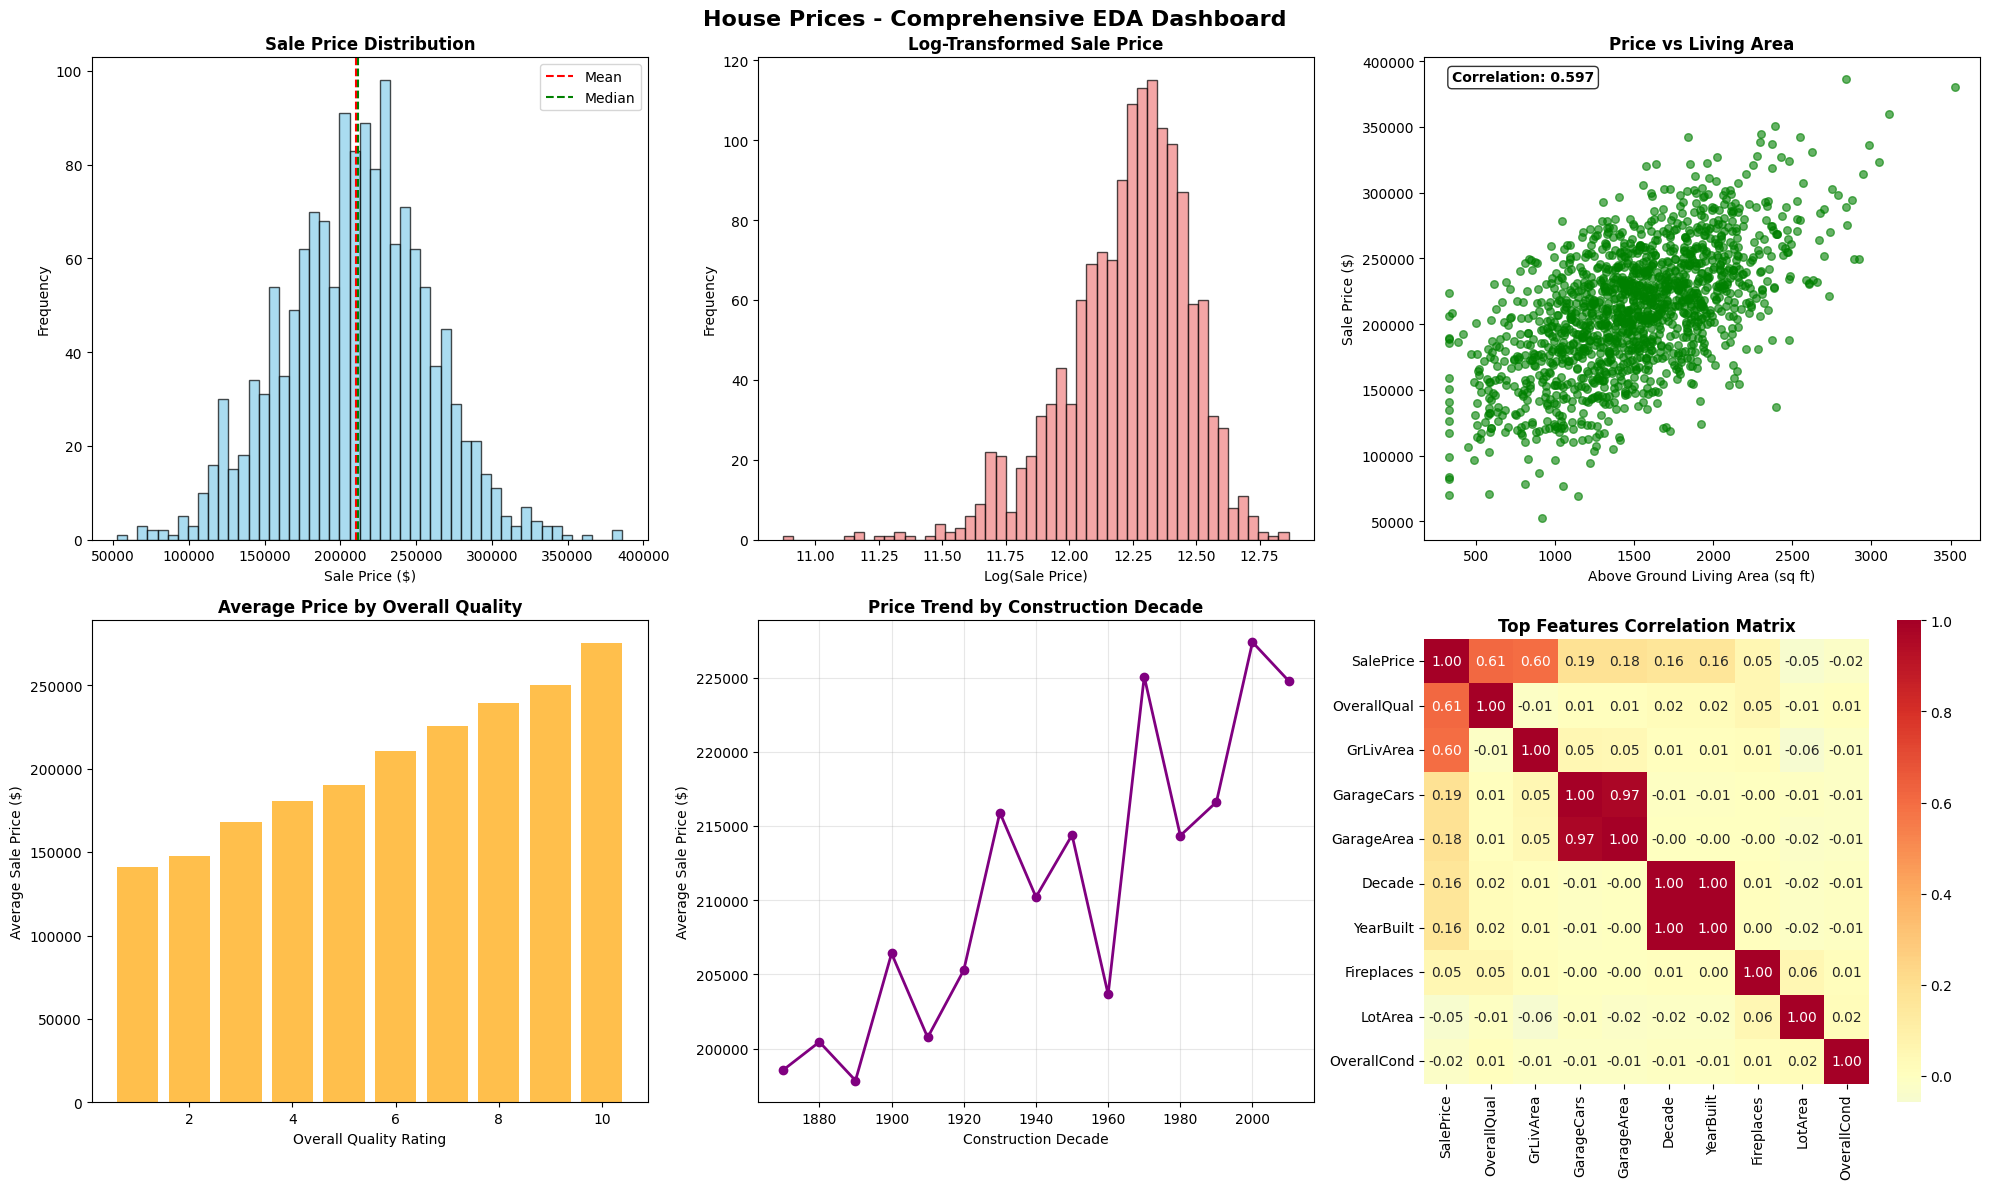


Key Insights from Eda:
Top 5 Most Correlated Features:
  1. OverallQual: 0.610
  2. GrLivArea: 0.597
  3. GarageCars: 0.187
  4. GarageArea: 0.183
  5. Decade: 0.162

==================== Phase 3: Feature Engineering ====================

Advanced Feature Engineering
Combined dataset shape: (2919, 19)

 1.Mathematical Transformations
Created TotalSF (Basement + Living Area)
Created LivingAreaRatio (efficiency metric)
Created HouseAge and IsNew features

 2.Categorical Feature Engineering
Created NeighborhoodGroup (market segmentation)
Created QualityScore (Quality × Condition)

 3. Interaction Features
Created SizeQualityInteraction
Created GarageScore and HasGarage

 4.Statistical Transformations
Identified 3 skewed features for transformation
Log-transformed LotArea
Log-transformed LivingAreaRatio

 5.Advanced Missing Value Treatment
Total missing values: 1459
Applied domain-specific missing value imputation

 6.Feature Scaling Preparation
Identified 2 high-variance features
Feature

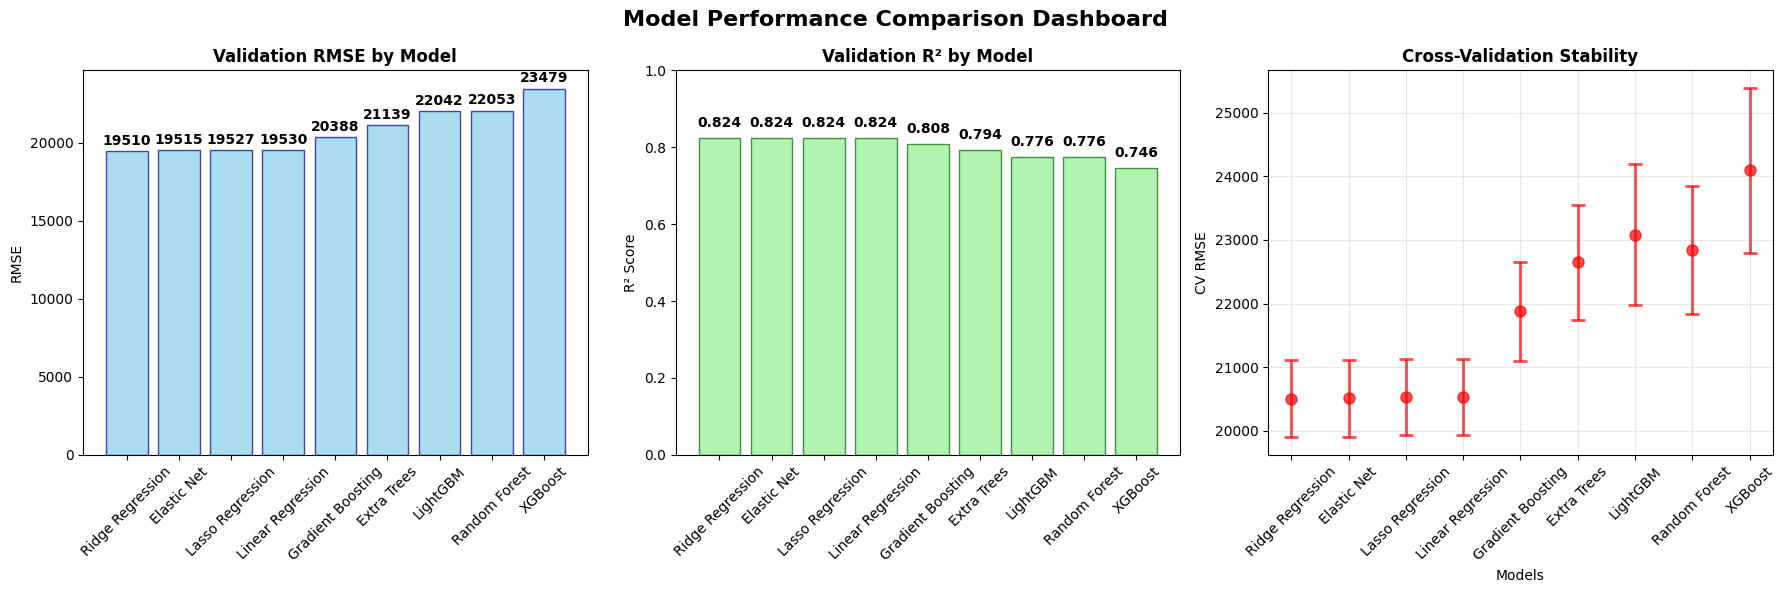


==================== Phase 6: Model Optimization ====================

 Advanced Hyperparameter Tuning
Optimizing: {best_model_name}
Performing GridSearchCV for Ridge Regression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Tuning Results:
Original RMSE: 19510.24
Tuned RMSE:    19425.32
Improvement:   0.4%

Original R²:   0.8244
Tuned R²:      0.8260

 Best Parameters:
   alpha: 10

==================== Phase 7: Model Analysis ====================

Feature Importance Analysis
Model: Ridge Regression
Top 15 Features by Coefficient Magnitude:
   Feature   Coefficient
 Feature_2  25431.012725
 Feature_4  23766.310904
Feature_31  15521.134947
Feature_13  12967.783687
Feature_45 -12936.960814
Feature_35  -9561.843019
Feature_18   8728.699519
 Feature_5  -8360.735892
Feature_12   7683.178242
Feature_33   6977.668887
 Feature_6   6050.934444
Feature_41  -4990.868520
Feature_28   4982.927419
Feature_23   4347.164534
 Feature_7   3537.648932

Model Diagnostics & Validation
Mo

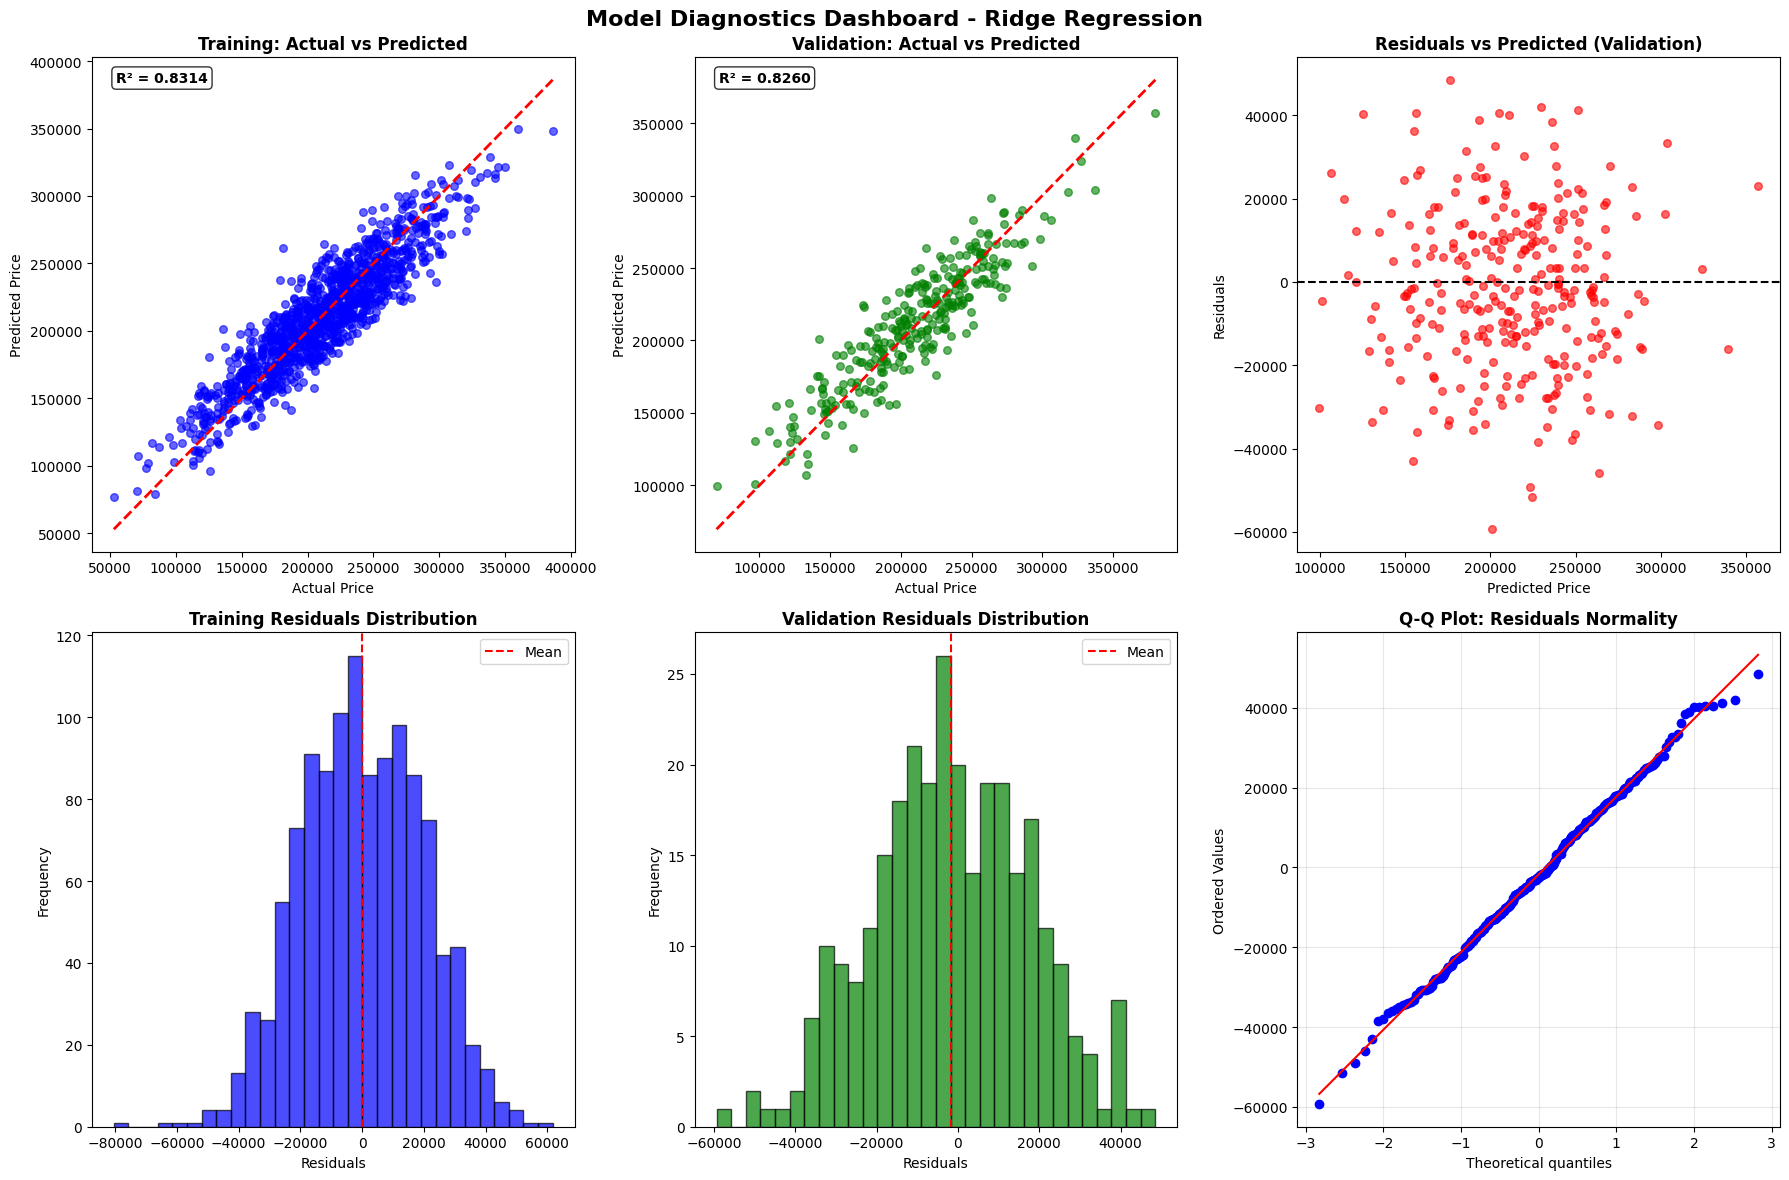


 Diagnostic Statistics:
Training RMSE:     19700.49
Validation RMSE:   19425.32
Training R²:       0.8314
Validation R²:     0.8260
Training MAE:      16069.10
Validation MAE:    15694.77

 Overfitting Analysis:
RMSE Difference (Val - Train): -275.17
R² Difference (Train - Val):   0.0054
Model shows good generalization

 Residual Analysis:
Mean residual:     -1738.58
Residuals std:     19380.57
Residuals skew:    -0.021

==================== PHASE 8: Final Prediction ====================

Generating Final Prediction
Generated 1459 predictions
Prediction range: $62,736 - $349,998
Mean prediction: $210,465
Submission saved as 'house_prices_submission.csv'

==================== Project Summary ====================
Best Model: Ridge Regression
Final RMSE: 19425.32
Final R²: 0.8260
Model Generalization: Good
Submission file: house_prices_submission.csv

Project Completed Successfully!
Key achievements:
Comprehensive EDA with business insights
Advanced feature engineering techniques
Multipl

In [21]:
if __name__ == "__main__":
    print("House Price Prediction")
    print("=" * 70)
    
    # Initializing the predictor
    predictor = HousePricePredictor()
    
    # Running the complete pipeline
    results = predictor.run_complete_pipeline()
    
    if results:
        print("\nProject Execution Completed!")
    else:
        print("\nProject execution encountered issues. Please review the code.")